# Lab 3 Extra: Deep Gaussian Processes
### Gaussian Process Summer School 2020
In this extra lab, we introduce practical use of _deep Gaussian processes_, expanding on the talk given this morning.

The level of this notebook is aimed as an introduction to deep GPs, but will assume some familiarity of topics from labs 1 and 2, including regression and using inducing variables for scalable inference.

This notebook makes use of [`PyDeepGP`](https://github.com/SheffieldML/PyDeepGP).

## 1. Getting started

Make sure that you have the appropriate packages installed, including `PyDeepGP`: you can review the [Getting Started](https://gpss.cc/gpss19/getting_started/) page for detailed instructions.

First, we will setup the notebook with libraries we are going to use. As in previous labs, we will use `GPy`.

In [2]:
# Support for maths
import numpy as np
# Plotting tools
from matplotlib import pyplot as plt
# we use the following for plotting figures in jupyter
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

# GPy: Gaussian processes library
import GPy

# PyDeepGP: Deep Gaussian processes
import deepgp

### Recap: Gaussian Process Regression

Recall, from Lab 2, the data for the winners of the Olympic men's marathon. We will use this again to highlight limitations with standard GPs and demonstrate how we can make use of deep GPs for such a problem.

In [3]:
import pickle
import requests

req = requests.get('https://github.com/gpschool/labs/raw/2023/.resources/olympic_marathon_men')
data = pickle.loads(req.content)

X, y = data['X'], data['Y'] # X represents the year, and y are the average pace of the winner

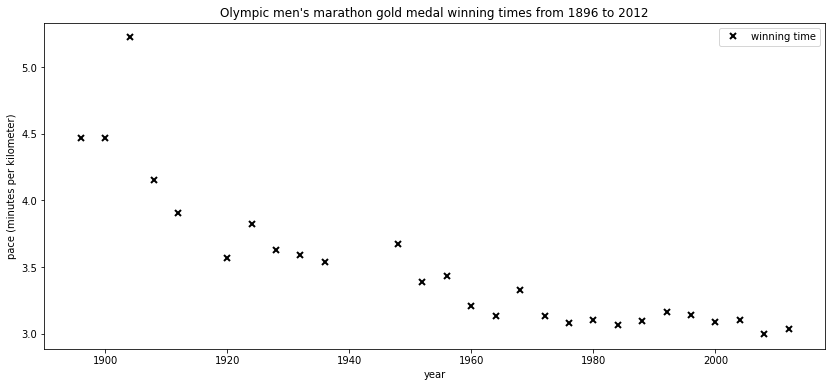

In [4]:
# Set up our plotting environment
plt.figure(figsize=(14, 6))

# Plot the training data, the results of the gold medal winning time for the Olympic men's marathon
plt.plot(X, y, "kx", mew=2)

# Annotate plot
plt.legend(labels=["winning time"]), plt.xlim((1890, 2018))
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)")
plt.title("Olympic men's marathon gold medal winning times from 1896 to 2012");

By now, you should be familiar with fitting a GP using `GPy`. We will fit a standard `RBF` kernel. Note that we are using a Gaussian likelihood, and have a constant mean for our GP (to be optimised).

In [5]:
m_full = GPy.models.GPRegression(
    X, y,
    mean_function=GPy.mappings.Constant(1,1),
    kernel=GPy.kern.RBF(1)
)

m_full.optimize(messages=False)
display(m_full)

GP_regression.,value,constraints,priors
constmap.C,3.588241542106817,,
rbf.variance,0.27960601526401524,+ve,
rbf.lengthscale,20.79707416237302,+ve,
Gaussian_noise.variance,0.04190680752640822,+ve,


This is utility code from previous labs, adapted slightly so that it will work with deep GPs as well

In [6]:
def plot_gp(model, X, training_points=False):
    """ Plotting utility to plot a GP fit with 95% confidence interval """
    # Plot 95% confidence interval 
    m, _ = model.predict(X)
    lci, uci = model.predict_quantiles(
        X,
        (2.5, 97.5)
    )
    plt.fill_between(X[:,0], lci[:,0], uci[:,0], alpha=0.5)
    
    # Plot GP mean and initial training points
    plt.plot(X, m, "-")
    plt.legend(labels=["GP fit"])
    
    plt.xlabel("x"), plt.ylabel("f")
    
    # Plot training points if included
    if training_points:
        X_, Y_ = model.X, model.Y
        plt.plot(X_, Y_, "kx", mew=2)
        plt.legend(labels=["GP fit", "sample points"])

We can see that plotting the GP, we struggle to handle the outlier, giving an suboptimial fit.

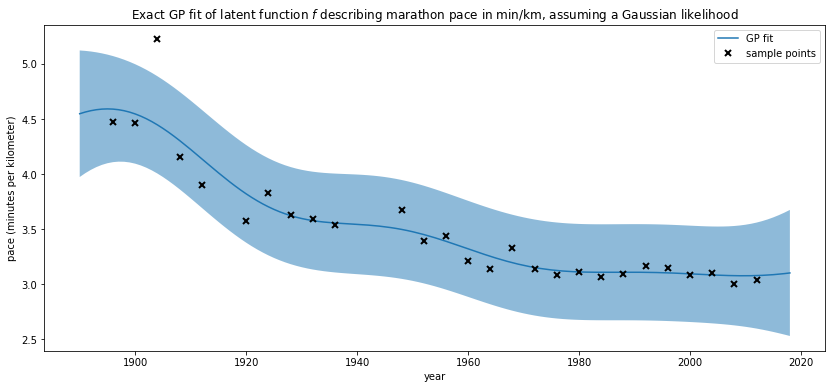

In [7]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

plt.figure(figsize=(14,6))
# Plot the GP prediction of the latent function with training points
plot_gp(m_full, Xnew, training_points=True)
# Annotate plot
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)")
plt.title("Exact GP fit of latent function $f$ describing marathon pace in min/km, assuming a Gaussian likelihood");

## 2. Deep GP Regression

As we have seen before, the GP struggles to fit to the observations due to the presence of the outlier in 1904. Previously, in Lab 2, we modelled this with a non-Gaussian likelihood to give a heavy-tailed output using a Student's T-distribution. An alternative way to deal with the non-Gaussian is to construct a hierarchical model: a deep GP with two layers.

$$
    y = f_1(f_2(x)),\quad \mathrm{where}\ f_1\sim \mathcal{GP}\ \mathrm{and}\ f_2 \sim \mathcal{GP}
$$

We are essentially constructing the function, 
$$f : \mathbf{x} \underset{f_2}{\mapsto} \mathbf{z} \underset{f_1}{\mapsto}y,$$
where $\mathbf{z}$ is a latent variable in the hierarchical model. We can refer to $\mathbf{z}$ as a 'layer' in a deep model.

We will no construct our deep GP using `pyDeepGP`. We have one hidden variable (or layer), and will initialise our latent representations with principle component analysis (PCA).

For simplicity, we use the Gaussian RBF kernel for each layer, and have 1-D latent variables.

In [8]:
num_hidden = 1
latent_dim = 1

kernels = [*[GPy.kern.RBF(latent_dim, ARD=True)]*num_hidden] # hidden kernels
kernels.append(GPy.kern.RBF(X.shape[1])) # we append a kernel for the input layer

m_deep = deepgp.DeepGP(
    # this describes the shapes of the inputs and outputs of our latent GPs
    [y.shape[1], *[latent_dim]*num_hidden, X.shape[1]],
    X = X, # training input
    Y = y, # training outout
    inits = [*['PCA']*num_hidden, 'PCA'], # initialise layers
    kernels = kernels,
    num_inducing = 50,
    back_constraint = False
)

In [9]:
m_deep.initialize_parameter()
display(m_deep)

deepgp.,value,constraints,priors
obslayer.inducing inputs,"(50, 1)",,
obslayer.rbf.variance,1.0,+ve,
obslayer.rbf.lengthscale,1.0,+ve,
obslayer.Gaussian_noise.variance,1.0,+ve,
obslayer.Kuu_var,"(50,)",+ve,
obslayer.latent space.mean,"(27, 1)",,
obslayer.latent space.variance,"(27, 1)",+ve,
layer_1.inducing inputs,"(50, 1)",,
layer_1.rbf.variance,1.0,+ve,
layer_1.rbf.lengthscale,1.0,+ve,


### Optimising a Deep GP

Reflecting on the defined model, we can see that we have $260$ parameters to optimise, including kernel and likelihood hyperparameters and inducing inputs and variables for each layer, as well as the latent parameters.

You may find that running the optimisation as is will cause a collapse of the Gaussian noise in each layer, causing failure of the optimiser. In the next cell, we construct a utility function to reset the variance to $1.0$ to try and avoid this:

In [10]:
def optimise_dgp(model, messages=True):
    ''' Utility function for optimising deep GP by first
        reinitiailising the Gaussian noise at each layer
        (for reasons pertaining to stability)
    '''
    model.initialize_parameter()
    for layer in model.layers:
        layer.likelihood.variance.constrain_positive(warning=False)
        layer.likelihood.variance = 1. # small variance may cause collapse
    model.optimize(messages=messages, max_iters=10000)

Now, let's try optimising the deep GP. You may find that the optimisation fails with status `Errorb'ABNORMAL_TERMINATION_IN_LNSRCH`: just try rerunning the cell.

In [11]:
optimise_dgp(m_deep, messages=True)

We can plot our deep GP in the same fit as before, by calling `predict()` and `predict_quantiles()` to obtain a moments and quantiles from the optimised deep GP in the observation domain:

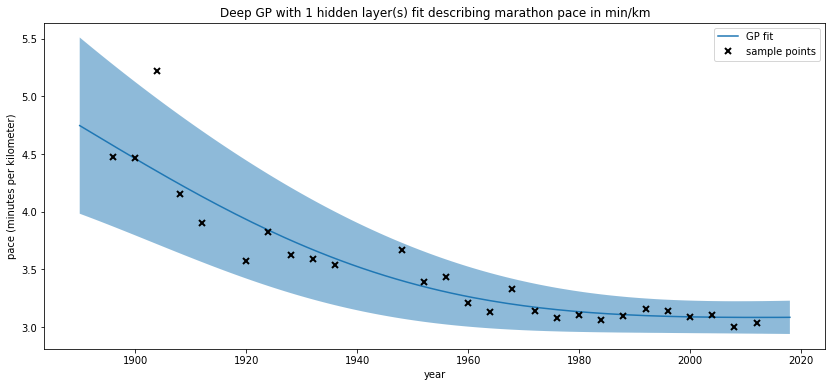

In [12]:
Xnew = np.arange(1890,2019)[:, None] # predict winning pace every year between 1890 and 2018

plt.figure(figsize=(14,6))

# Plot the our deep GP prediction
plot_gp(m_deep, Xnew, training_points=True)

# Annotate plot
plt.xlabel("year"), plt.ylabel("pace (minutes per kilometer)")
plt.title("Deep GP with %d hidden layer(s) fit describing marathon pace in min/km" % num_hidden);

### Visualising Mappings

As we can see, the deep GP performs much better than the standard GP fit. We may also find it interesting to look at both the individual functions mapping between layers.

We can visualise the latent mappings by propagating the input through layers -- since each output is multivariate Gaussian by virtue of the mappings being GPs, we can plot the uncertainty of the latent functions at each layer.

In [13]:
def plot_dgp_layers(model, X, training_points=True, axsize=(14,6)):
    ''' Plot mappings between layers in a deep GP '''
    if not isinstance(model, deepgp.DeepGP):
        return plot_gp(model, X) # catch a batch GP

    num_layers  = len(model.layers) # Get number of layers
    layer_input = X # The first input
    
    _, axs = plt.subplots(num_layers, 1, figsize=(axsize[0], axsize[1]*num_layers))
    
    # The layers in a deep GP are ordered from observation to input,
    # ... we will plot them from input to output, so reverse the layers
    layers = list(reversed(model.layers))
    for i, layer in enumerate(layers):
        # We get the mean and confidence intervals of the layer
        mu_i, _ = layer.predict(layer_input, include_likelihood=False)
        lci_i, uci_i = layer.predict_quantiles(layer_input, (2.5, 97.5))
        # Plot mean and 95% CI of latent function
        axs[i].plot(layer_input, mu_i)
        axs[i].fill_between(layer_input[:,0], lci_i[:,0], uci_i[:,0], alpha=0.5)
        # Annotate plot
        axs[i].set_ylabel(layer.name)
        axs[i].set_xlabel(layers[i-1].name if i > 0 else "input")
        axs[i].set_title("$f_%d$" % (num_layers-i))
        # Set mean as input for next layer
        layer_input = np.linspace(*min(lci_i), *max(uci_i), num=100)[:,None]
        
        if training_points: # Plot propagated training points
            axs[i].plot(
                layer.X.mean.values if i > 0 else layer.X,
                layer.Y.mean.values if i < num_layers-1 else layer.Y,
                'kx', mew=2
            )

We now plot our two GPs that form the hierarchical (deep) GP. The first maps the input domain to the first latent space, and the second maps from that latent space into space of our observation model.

$$y = f_1(f_2(x))$$

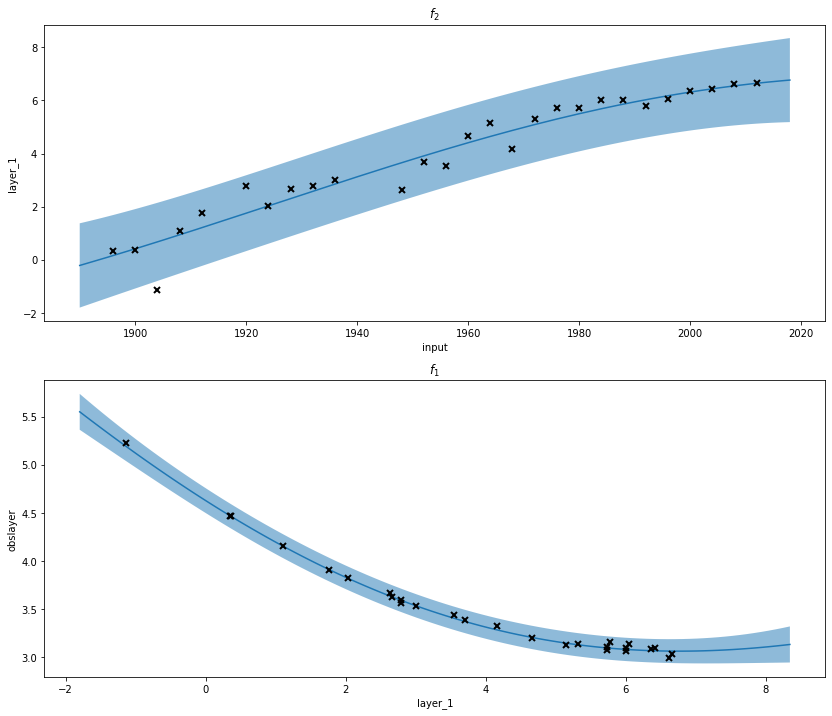

In [14]:
plot_dgp_layers(m_deep, Xnew, training_points=True, axsize=(14, 6))

### Sampling

As with all models, we might want to sample from the posterior. We can do this with the mean and covariance of our GP layers, and use these to create random samples -- by the nature of the model, each sample from the first layer forms the input to the second. You can see the code to perform this below:

In [15]:
def sample_dgp(model, X, num_samples=1, include_likelihood=True):
    ''' Sample from a hierarchical GP by propagating
        samples through layers
    '''
    samples = []
    jitter = 1e-5
    count, num_tries = 0, 100
    while len(samples) < num_samples:
        next_input = X
        if count > num_tries:
            print("failed to sample")
            break
        try:
            count = count + 1
            for layer in reversed(model.layers):
                mu_k, sig_k = layer.predict(
                    next_input, full_cov=True, include_likelihood=include_likelihood
                )
                sample_k = mu_k + np.linalg.cholesky(sig_k + jitter*np.eye(X.shape[0]))@np.random.randn(*X.shape)
                next_input = sample_k
            samples.append(sample_k)
            count = 0
        except:
            pass
        
    return samples if num_samples > 1 else samples[0]

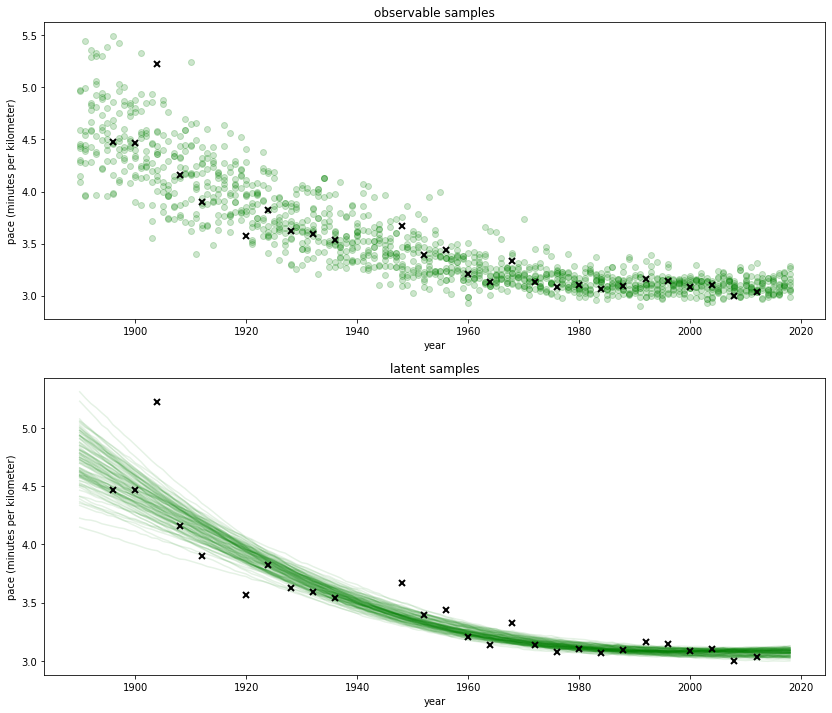

In [16]:
_, axs = plt.subplots(2,1, figsize=(14,12))

samples = sample_dgp(m_deep, Xnew, 10, include_likelihood=True)
for sample in samples:
    axs[0].plot(Xnew, sample, 'go', alpha=0.2)
axs[0].plot(X, y, 'kx', mew=2)
axs[0].set_title("observable samples")

samples = sample_dgp(m_deep, Xnew, 100, include_likelihood=False)
for sample in samples:
    axs[1].plot(Xnew, sample, 'g-', alpha=0.1)
axs[1].plot(X, y, 'kx', mew=2)
axs[1].set_title("latent samples")

[(ax.set_xlabel("year"), ax.set_ylabel("pace (minutes per kilometer)")) for ax in axs];

### Exercise:

Now you have seen how we can fit a deep GP to data, and sample from the posterior. Using the following utility code snippets, construct a deep GP prior and same from it. Apply standard and deep GP regression to the model, and comment on the results.

In [17]:
def gp_prior_sample(x, kern=GPy.kern.RBF):
    ''' '''
    if not isinstance(kern, GPy.kern.Kern):
        kern = kern(x.shape[1], ARD=True)
    mu = np.zeros((x.shape[0]))
    C  = kern.K(x,x)
    return np.random.multivariate_normal(mu, C, 1).T

def deepgp_prior_sample(x, kernels=[GPy.kern.RBF]):
    ''' Sample from hierarchical model: f = f1(f2(...fn(x)))
           where fi ~ GP(0,Ki) and Ki = kernels[i].K
    '''
    z = x
    for kern in reversed(kernels):
        z = gp_prior_sample(z, kern=kern)
    return z

> Using the utility code, we can easily sample using a list of kernels. In the below example, we define a GP with three warping layers, each with an RBF kernel defined using different hyperparameter values.

In [18]:
kernels = [
    GPy.kern.RBF(1, lengthscale=0.2),
    GPy.kern.RBF(1, variance=0.1, lengthscale=0.5),
    GPy.kern.RBF(1, lengthscale=0.1)
] # The kernels for our respective layers

Xnew  = np.linspace(0., 1., num=1000)[:,None]

np.random.seed(458)
f  = deepgp_prior_sample(Xnew, kernels=kernels) #f1(f2(f3(Xnew)))
X  = Xnew[::10]
y  = f[::10] + 0.1*np.random.randn(*X.shape)

> We can plot our samples, and observe the erratic behaviour of the curve. It should be clear that fitting a standard GP would not give a reliable fit.

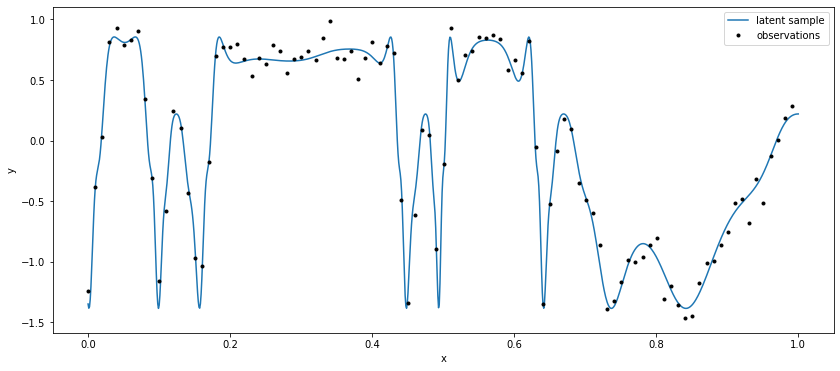

In [19]:
plt.figure(figsize=(14,6))
plt.plot(Xnew, f,'-', X, y, 'k.')
plt.xlabel('x'), plt.ylabel('y'), plt.legend(labels=['latent sample','observations']);

> We will try and regress this data using the same kernel list, and apply hyperparameter optimisation for good measure.

In [20]:
num_hidden = len(kernels) - 1
latent_dim = 1

m_deep = deepgp.DeepGP(
    # this describes the shapes of the inputs and outputs of our latent GPs
    [y.shape[1], *[latent_dim]*num_hidden, X.shape[1]],
    X = X, # training input
    Y = y, # training outout
    inits = [*['PCA']*num_hidden, 'PCA'], # initialise layers
    kernels = kernels,
    num_inducing = 100,
    back_constraint = False
)

optimise_dgp(m_deep)


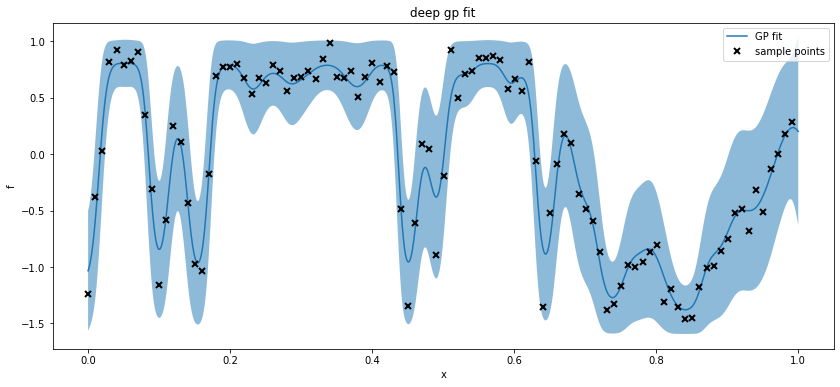

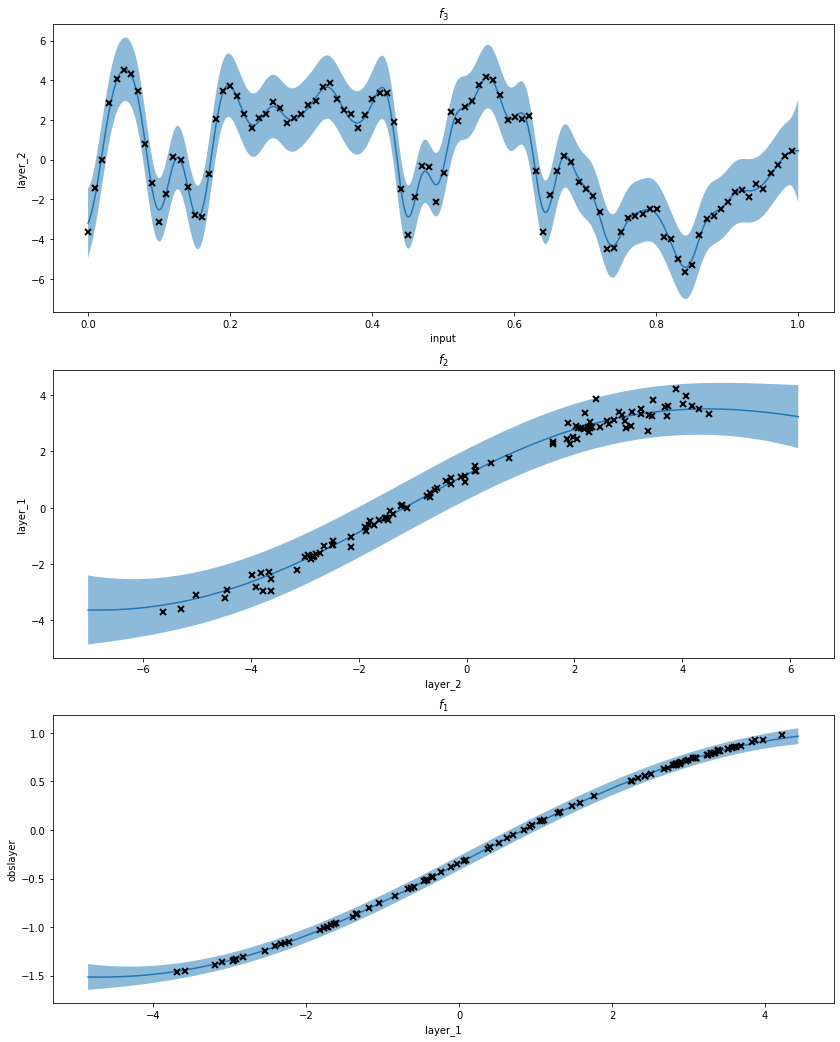

In [21]:
plt.figure(figsize=(14,6))
plot_gp(m_deep, Xnew, training_points=True)
plt.title("deep gp fit")

plot_dgp_layers(m_deep, Xnew)

## 3. Approximating Discontinuities

One of the benefits of deep Gaussian processes is that we can warp the latent GPs non-linearly, which helps model more complex structures, such as step discontinuties. In this section, we will show an example of how a deep GP can be used to model a rectangle function, and compare it to a standard GP.

First, we will create some data from a rectangle function, with the upper and lower parts overlapping randomly:

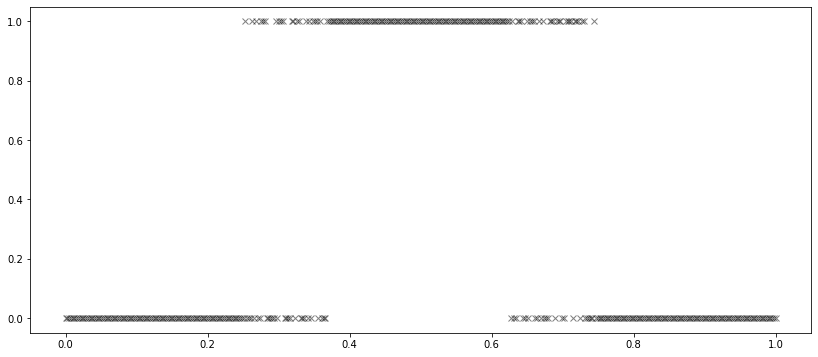

In [22]:
def overlapping_rect(scale=1.):
    ''' Create a rectangle function with overlap in upper and lower layers'''
    x = np.linspace(0., 1., 400)
    y = np.hstack([np.zeros(100), np.random.choice([0., 1.], size=(50,)), np.ones(100), np.random.choice([0., 1.], size=(50,)), np.zeros(100)])
    return x[:,None], scale*y[:,None]

# We generate and plot our data (not that there is no added noise)
X, y = overlapping_rect()

plt.figure(figsize=(14, 6))
plt.plot(X, y, 'kx', alpha=0.5);

As we know from previous labs, fitting a GP to this will be difficult because of the inherent smoothness assumed. However, we will fit and plot one all the same, just for comparison:

In [23]:
m_full = GPy.models.GPRegression(X, y, kernel=GPy.kern.RBF(1))
m_full.optimize()
display(m_full)

GP_regression.,value,constraints,priors
rbf.variance,0.25108908411561914,+ve,
rbf.lengthscale,0.2106072855483116,+ve,
Gaussian_noise.variance,0.07030460599179972,+ve,


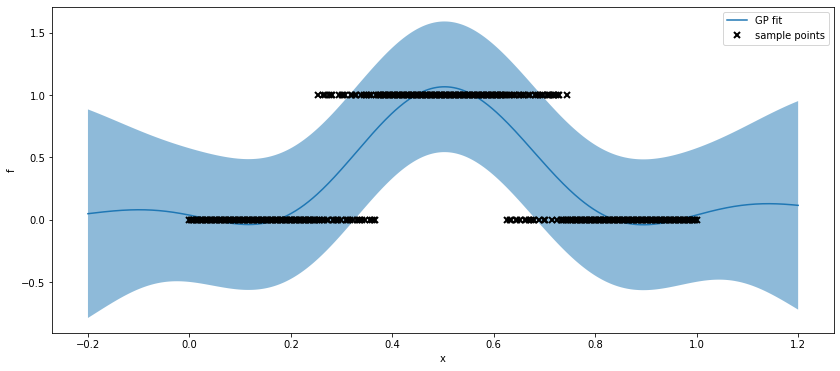

In [24]:
Xnew = np.linspace(-0.2, 1.2, num=500)[:,None]
plt.figure(figsize=(14,6))
plot_gp(m_full, Xnew, training_points=True)

As we can see, the GP struggles with the discontinuties and gives us an overly uncertain, and smooth fit.

We will now try a simple 3-layer deep GP, $y = f_1(f_2(f_3(x)))$, with RBF kernels at each layer.

In [25]:
num_hidden = 2

m_deep = deepgp.DeepGP(
    [y.shape[1], *[1]*num_hidden, X.shape[1]],
    X = X,
    Y = y,
    init = [*['PCA']*num_hidden, 'PCA'],
    kernels = [*[GPy.kern.RBF(1, ARD=True)]*num_hidden, GPy.kern.RBF(1)],
    num_inducing = 50,
    back_constraint=False
)
optimise_dgp(m_deep)

We plot the fit now, and as we can see, the is close to the observations, with the greatest uncertainty occuring in the overlapping discontinuties. 

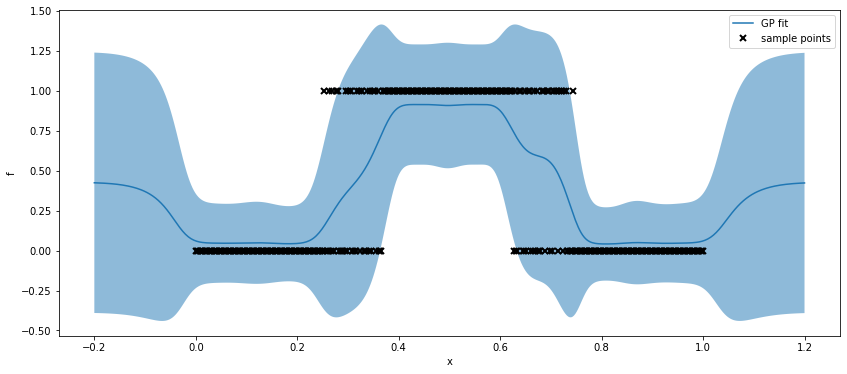

In [26]:
plt.figure(figsize=(14,6))
plot_gp(m_deep, Xnew, training_points=True)

We can look at the samples from the posterior, of both simulated observations and of the latent GPs. We can see that while the samples are not tightly fit to 0 or 1, we observe a reasonable behaviour representing the rectangle function (which we have treated as continuous). Notably, if we look to the edges of the plot, where we are sampling at input from which we have no observations, the behaviour is modelling the step functionality as a possibility.

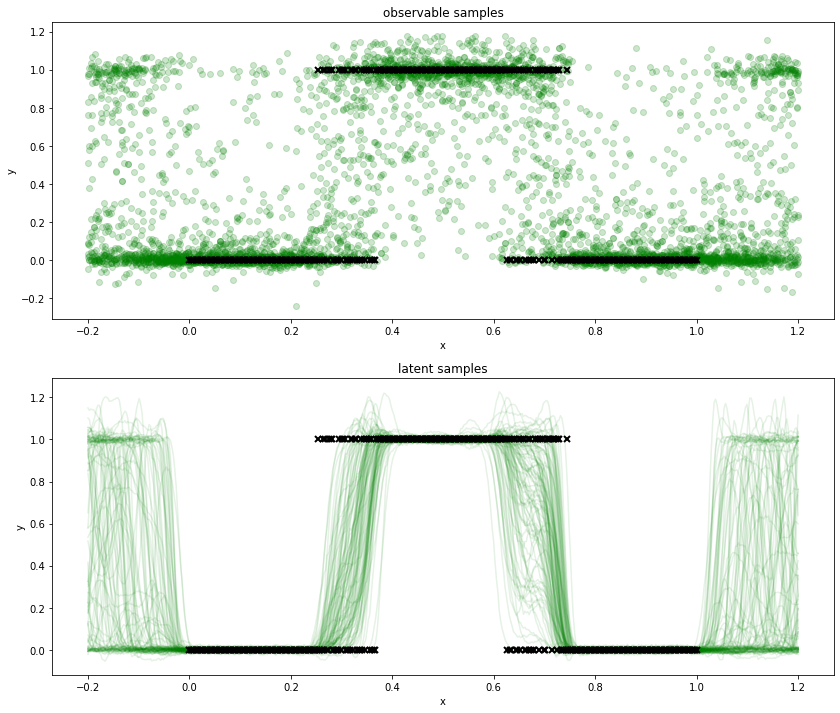

In [27]:
_, axs = plt.subplots(2,1, figsize=(14,12))

samples = sample_dgp(m_deep, Xnew, 10, include_likelihood=True)
for sample in samples:
    axs[0].plot(Xnew, sample, 'go', alpha=0.2)
axs[0].plot(X, y, 'kx', mew=2)
axs[0].set_title("observable samples")

samples = sample_dgp(m_deep, Xnew, 100, include_likelihood=False)
for sample in samples:
    axs[1].plot(Xnew, sample, 'g-', alpha=0.1)
axs[1].plot(X, y, 'kx', mew=2)
axs[1].set_title("latent samples")

[(ax.set_xlabel("x"), ax.set_ylabel("y")) for ax in axs];

### Exercise

Plot the different layers of the GP and comment on the warping. Can you explain why we are observing simulated discontinuities in the extrapolated regions? 

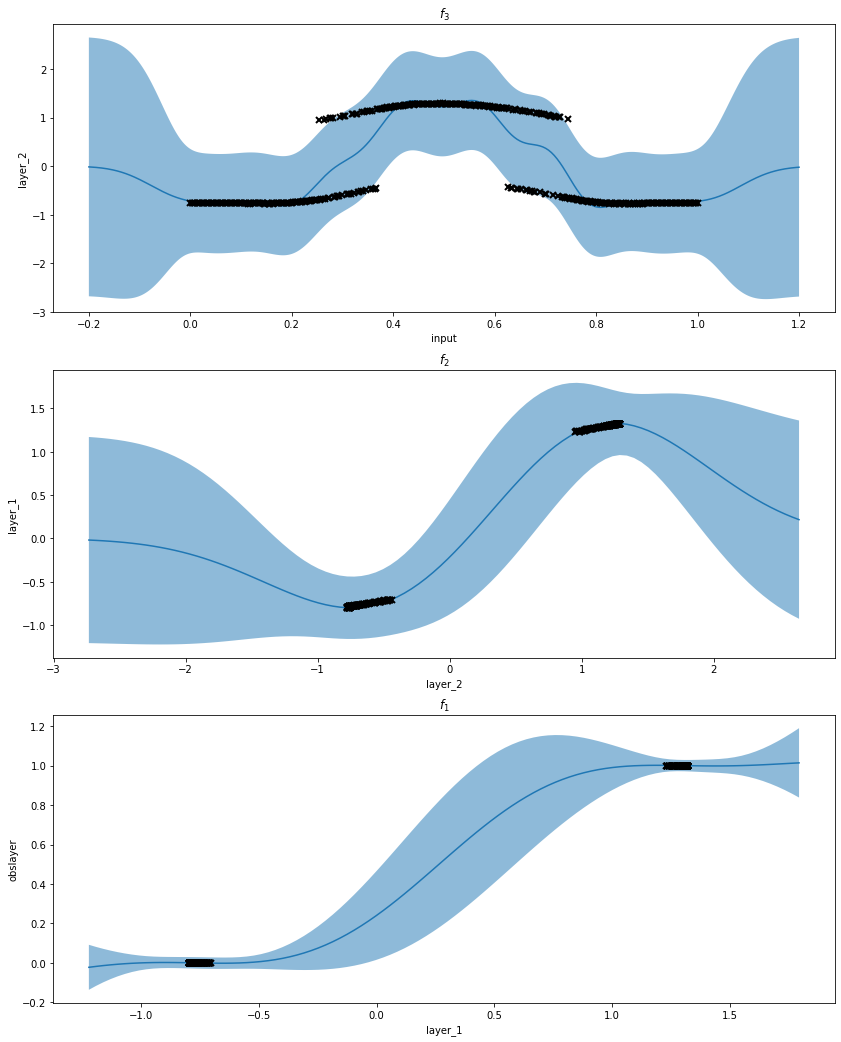

In [28]:
plot_dgp_layers(m_deep, Xnew, training_points=True)

> Looking at the warping, we can see that in the final layer before observation, we have essentially learned a sigmoid function which quite rapidly maps data to either 0 or 1 given the input. Observing the range of likely inputs from the preceding warping function, f2, we can see simlar form where most of the data is warped to either approximately -1 or 1.5, which respectively map to 0 and 1 in f1.

> Note that we may not have learned the optimal model, and you may want to adapt the model, in terms of, e.g. the number and dimension of hidden layers, and the kernels describing the underlying GPs.

---
### Credit

This notebook was written by Wil Ward, based on documentation of PyDeepGP and talks by [Neil Lawrence](http://inverseprobability.com/). 